In [60]:
import warnings
warnings.filterwarnings('ignore')

import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from landlab.components import OverlandFlow, FlowAccumulator, SpatialPrecipitationDistribution, FlowDirectorSteepest, NetworkSedimentTransporter
from landlab.data_record import DataRecord
from landlab.grid.network import NetworkModelGrid
from landlab.plot import graph
from landlab.io import read_shapefile
from landlab import ExampleData
from landlab.plot.imshow import imshow_grid, imshow_grid_at_node
from landlab.io.esri_ascii import read_esri_ascii

from landlab.plot import plot_network_and_parcels
%matplotlib inline

import matplotlib.colors as mcolors
colors = [(0,0.2,1,i) for i in np.linspace(0,1,3)]
cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=10)

Load shapefile of the drainage network

In [61]:
shp_file = '../data/hugo_links.shp'
points_shapefile = '../hugo_nodes_nodublicates.shp'

grid = read_shapefile(
    shp_file,
    threshold=0.1,
    )

Plot the Network

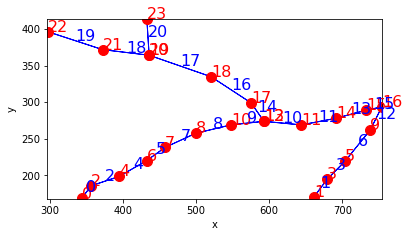

In [62]:
graph.plot_graph(grid, at="node,link")

#### Make a new grid that doesn't have duplicated nodes
* Nodes we don't want: 19, 13
* reassing all nodes_at_link that refensece the nodes we don't want 19-> 20, 12->13

In [63]:
#Drop double nodes
drop_nodes = [19,13]
new_y_of_node =[]
new_x_of_node =[]
#Find the new x and y coordinates
for i, node in enumerate(grid.y_of_node):
    if i not in drop_nodes:
        new_y_of_node.append(node)

for i, node in enumerate(grid.x_of_node):
    if i not in drop_nodes:
        new_x_of_node.append(node)

#rediect all nodes
replace_nodes = [20,12]
nodes_reformatted=np.ravel(grid.nodes_at_link)

for node, replacement in zip(drop_nodes,replace_nodes):
    nodes_reformatted[np.where(nodes_reformatted==node)]=replacement

#change index number     
for node in drop_nodes:
    nodes_reformatted[np.where(nodes_reformatted >node)] -=1
    
new_nodes_at_link=nodes_reformatted.reshape([21,2])

# Make a new network model grid
new_grid = NetworkModelGrid((new_y_of_node, new_x_of_node), new_nodes_at_link)

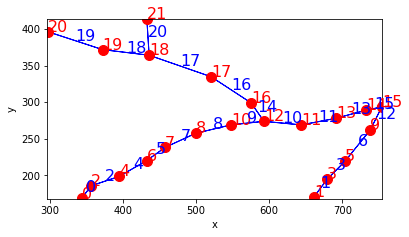

In [64]:
graph.plot_graph(new_grid, at="node,link")

### Setup the overland flow

In [65]:
#Define grid
# here we use an arbitrary, very small, "real" catchment
fname = '../data/hugo_site.asc'
rmg, z = read_esri_ascii(fname, name='topographic__elevation')
rmg.status_at_node[rmg.nodes_at_right_edge] = rmg.BC_NODE_IS_FIXED_VALUE
rmg.status_at_node[np.isclose(z, -9999.)] = rmg.BC_NODE_IS_CLOSED

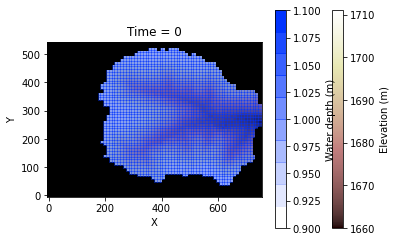

In [66]:
# Initial conditions
run_time =50000# 1 day 259200  # duration of run, (s) equivalent of 3 days
n = 0.01  # roughness coefficient, (s/m^(1/3))
g = 9.8  # gravity (m/s^2)
alpha = 0.7  # time-step factor (nondimensional; from Bates et al., 2010)
u = 0.4  # constant velocity (m/s, de Almeida et al., 2012)
elapsed_time = 1.0 #Elapsed time starts at 1 second. This prevents errors when setting our boundary conditions.
h_init = 1 # initial thin layer of water (m)

#Set up rain
rmg.at_node["surface_water__depth"] = np.zeros(rmg.number_of_nodes)
h = rmg.at_node['surface_water__depth']
h+=h_init #add a little bit of water everywhere

#ad a storm 
bools = (rmg.node_y > 100) * (rmg.node_y < 450) * (rmg.node_x < 400) * (rmg.node_x > 200)
h[bools] = 1 #initial water depth m

## Set inital discharge
rmg.at_node["surface_water__discharge"] = np.zeros(rmg.number_of_nodes)

fig1 = plt.figure()
imshow_grid(rmg,'topographic__elevation',colorbar_label='Elevation (m)')
imshow_grid(rmg,'surface_water__depth',cmap=cmap,colorbar_label='Water depth (m)')
plt.title(f'Time = 0')
plt.show()
fig1.savefig(f"Hima_results/runoff_0.jpeg")# print(rmg.at_node.keys())

### Start the sediment routing part

In [67]:
nmg_node_topo = np.zeros(new_grid.number_of_nodes) #create empty array holding elevations for network model grid
nmg_node_h = np.zeros(new_grid.number_of_nodes)

for i in range(new_grid.number_of_nodes):
    idx_nearest_raster_cell = rmg.find_nearest_node([new_grid.x_of_node[i], new_grid.y_of_node[i]])
    nmg_node_topo[i] = rmg.at_node["topographic__elevation"][idx_nearest_raster_cell]

Calculate distance between links

In [68]:
nmg_link_length = np.zeros(new_grid.number_of_links)
nmg_link_h = np.zeros(new_grid.number_of_links)

for i in range(new_grid.number_of_links):
    idx_node_1_link = new_grid.nodes_at_link[i][0]
    idx_node_2_link = new_grid.nodes_at_link[i][1]
    nmg_link_length[i] = np.sqrt((new_grid.x_of_node[idx_node_2_link] - new_grid.x_of_node[idx_node_1_link])**2 
                         + (new_grid.y_of_node[idx_node_2_link] - new_grid.y_of_node[idx_node_1_link])**2)
    
    nmg_link_h[i] = rmg.at_node['surface_water__depth'][idx_node_2_link] #assume second node is downstream one

In [69]:
new_grid.at_node["topographic__elevation"] = nmg_node_topo.copy()

new_grid.at_node["bedrock__elevation"] = nmg_node_topo.copy()

new_grid.at_link["channel_width"] = 10 * np.ones(grid.number_of_links)

new_grid.at_link["flow_depth"] = nmg_link_h.copy()

new_grid.at_link["reach_length"] = nmg_link_length

### Create a sediment parcels

In [70]:
# element_id is the link on which the parcel begins. 
element_id = np.repeat(np.arange(new_grid.number_of_links), 50)
element_id = np.expand_dims(element_id, axis=1)

volume = 1*np.ones(np.shape(element_id))  # (m3)
active_layer = np.ones(np.shape(element_id)) # 1= active, 0 = inactive
density = 2650 * np.ones(np.size(element_id))  # (kg/m3)
abrasion_rate = 0 * np.ones(np.size(element_id)) # (mass loss /m)

# Lognormal GSD
medianD = 0.002 # m
mu = np.log(medianD)
sigma = np.log(2) #assume that D84 = sigma*D50
np.random.seed(0)
D = np.random.lognormal(
    mu,
    sigma,
    np.shape(element_id)
)  # (m) the diameter of grains in each parcel

We begin by assigning each parcel an arbitrary (and small) arrival time and location in the link. 

In [71]:
time_arrival_in_link = np.random.rand(np.size(element_id), 1) 
location_in_link = np.random.rand(np.size(element_id), 1) 

We now collect the arrays into a dictionary of variables, some of which will be tracked through time (`["item_id", "time"]`), and others of which will remain constant through time :

In [72]:
lithology = ["quartzite"] * np.size(element_id)

variables = {
    "abrasion_rate": (["item_id"], abrasion_rate),
    "density": (["item_id"], density),
    "lithology": (["item_id"], lithology),
    "time_arrival_in_link": (["item_id", "time"], time_arrival_in_link),
    "active_layer": (["item_id", "time"], active_layer),
    "location_in_link": (["item_id", "time"], location_in_link),
    "D": (["item_id", "time"], D),
    "volume": (["item_id", "time"], volume)
}

With all of the required attributes collected, we can create the parcels DataRecord. Often, parcels will eventually transport off of the downstream-most link. To track these parcels, we have designated a "`dummy_element`" here, which has index value `-2`. 

In [73]:
items = {"grid_element": "link", "element_id": element_id}

parcels = DataRecord(
    new_grid,
    items=items,
    time=[0.0],
    data_vars=variables,
    dummy_elements={"link": [NetworkSedimentTransporter.OUT_OF_NETWORK]},
)

### Run the NetworkSedimentTransporter

In [74]:
dt_sed = 4000 # 60 * 60 * 24 *1# length of timestep (seconds) 

Before running the NST, we need to determine flow direction on the grid (upstream and downstream for each link). To do so, we initalize and run a Landlab flow director component: 

In [75]:
fd = FlowDirectorSteepest(new_grid, "topographic__elevation")
fd.run_one_step()

In [76]:
#Intialize model
#network sed transporter 
nst = NetworkSedimentTransporter(    
    new_grid,
    parcels,
    fd,
    bed_porosity=0.3,
    g=9.81,
    fluid_density=1000,
    transport_method="WilcockCrowe",
)
#overland flow 
of = OverlandFlow(rmg, steep_slopes=True)
of.run_one_step()

In [77]:
# look at hydorgraph at outlet 
hydrograph_time = []
discharge_at_outlet = []
height_at_outlet = []

#Define the outlet 
outlet_nearest_raster_cell = rmg.find_nearest_node([new_grid.x_of_node[14], new_grid.y_of_node[14]])# did not choose 15 since at boundary
outlet_link_to_sample = rmg.links_at_node[outlet_nearest_raster_cell][3]

Sed transporter run at model time:  0.0463025487227 days passed


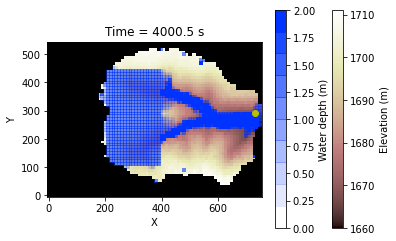

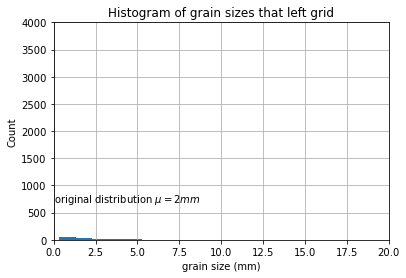

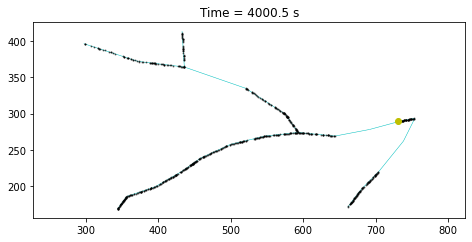

Sed transporter run at model time:  0.0926009302726 days passed


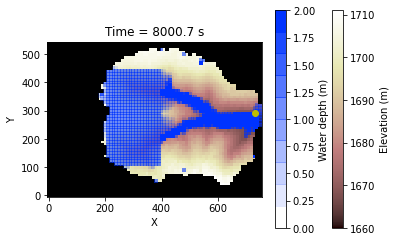

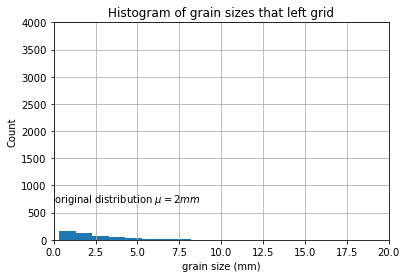

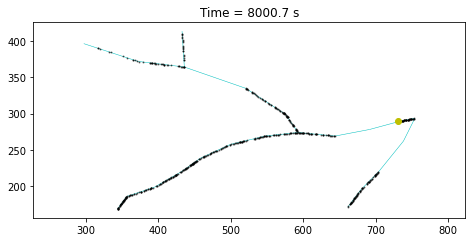

Sed transporter run at model time:  0.138896970623 days passed


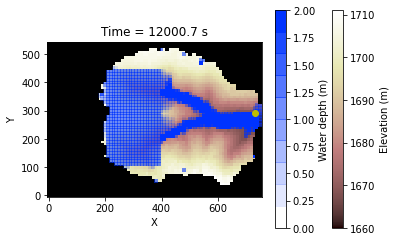

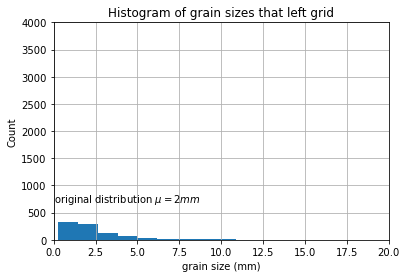

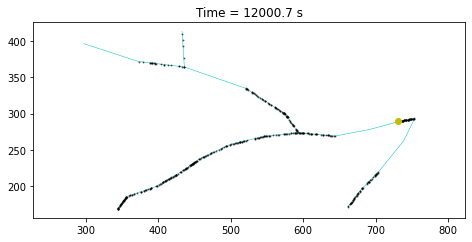

Sed transporter run at model time:  0.185185418136 days passed


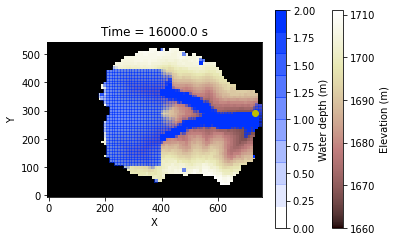

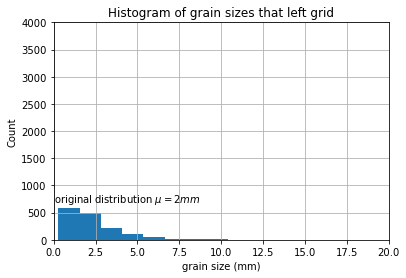

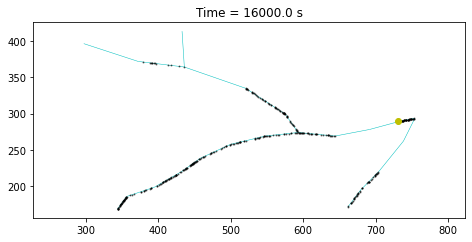

Sed transporter run at model time:  0.231486183477 days passed


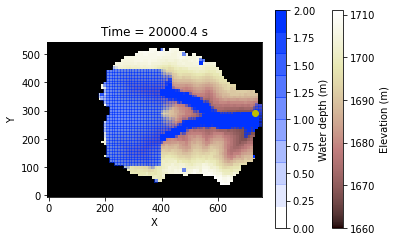

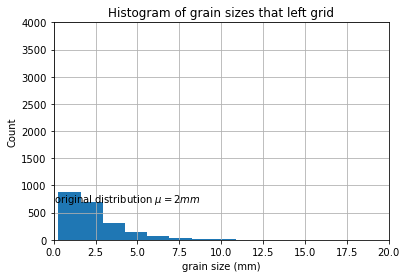

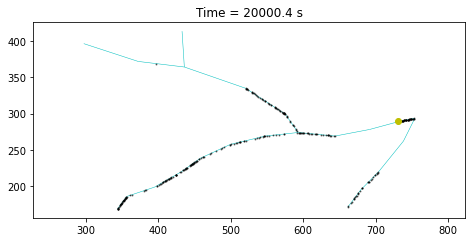

Sed transporter run at model time:  0.277784719151 days passed


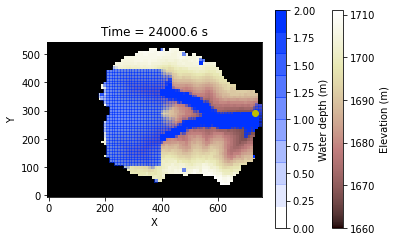

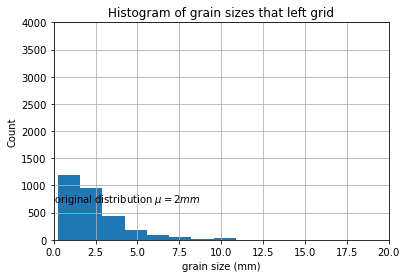

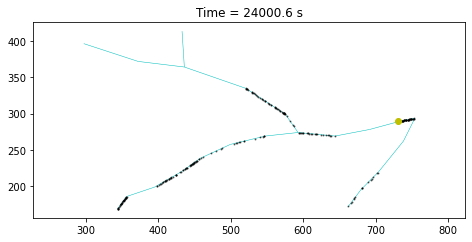

Sed transporter run at model time:  0.324079708014 days passed


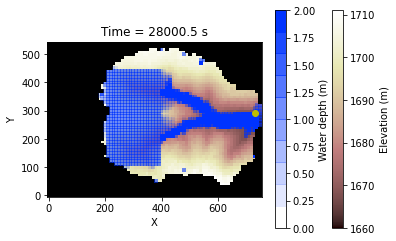

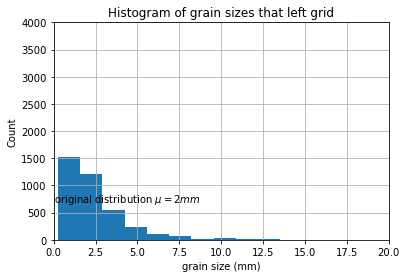

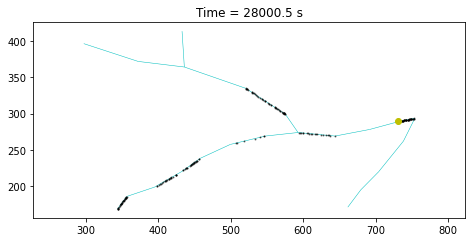

Sed transporter run at model time:  0.370377611693 days passed


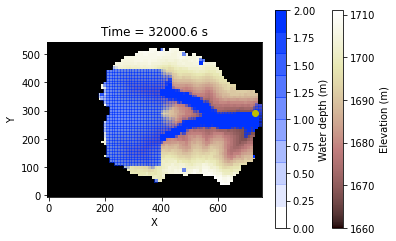

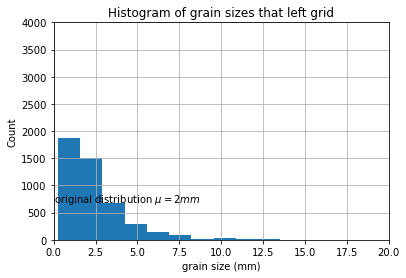

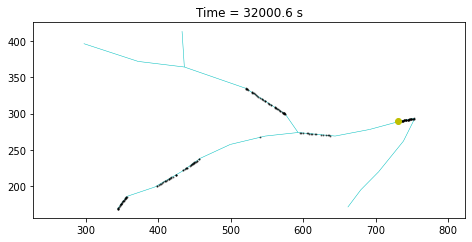

Sed transporter run at model time:  0.416672405491 days passed


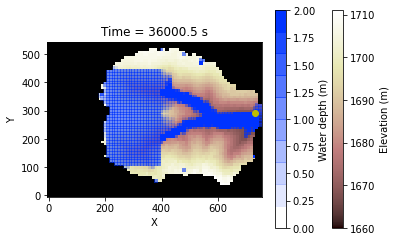

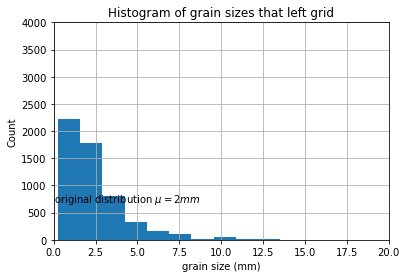

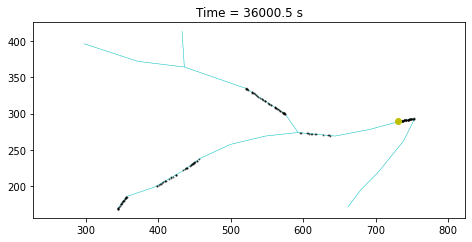

Sed transporter run at model time:  0.462968037474 days passed


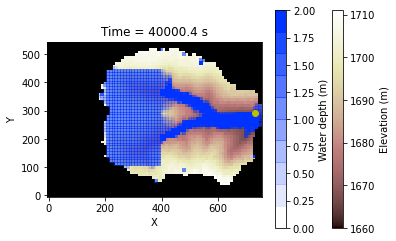

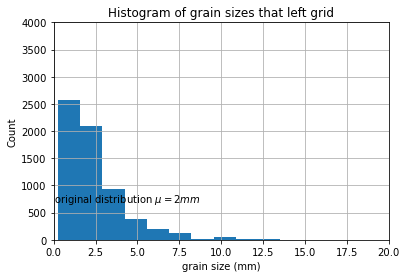

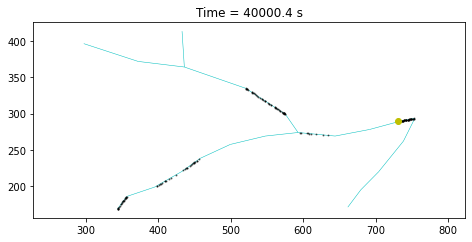

Sed transporter run at model time:  0.509262186201 days passed


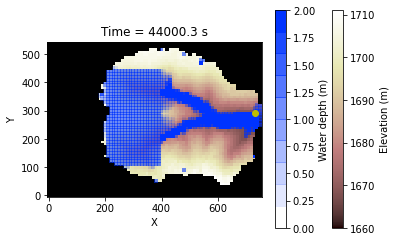

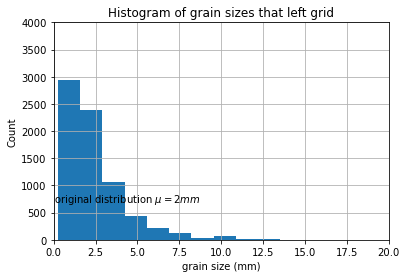

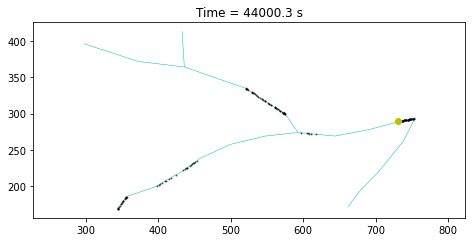

Sed transporter run at model time:  0.555559957486 days passed


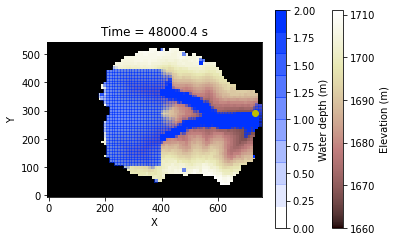

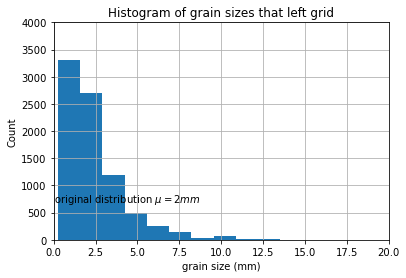

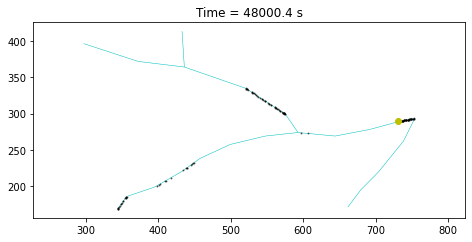

In [78]:
# this section can take selveral minutes to run

elapsed_time = 1.
run_time_slices = np.arange(dt_sed,run_time+1,dt_sed) #every sed transport timestep
  
#Run model
for t in run_time_slices:
    #Run overland until next time to run sed transport
    while elapsed_time < t: 
        # First, we calculate our time step.
        dt_overland = of.calc_time_step()
        # print('overland flow timestep is',dt_overland,'seconds')
        # Now, we can generate overland flow.
        of.overland_flow()
        # Increased elapsed time
        elapsed_time += dt_overland
        #print("Model time: ",elapsed_time/(60*60*24), "days passed")
        ## Append time and discharge and water depth to their lists to save data and for plotting.
        hydrograph_time.append(elapsed_time) 
        q = rmg.at_link["surface_water__discharge"]
        discharge_at_outlet.append(np.abs(q[outlet_link_to_sample]) * rmg.dx)
        h = rmg.at_node['surface_water__depth']
        height_at_outlet.append(np.abs(h[outlet_nearest_raster_cell]))
        
        #Make more rain 
        h[bools]=1#water depth m
    
    # updated the water depth in network graph
    for i in range(new_grid.number_of_links):
        idx_node_2_link = new_grid.nodes_at_link[i][1]
        nmg_link_h[i] = rmg.at_node['surface_water__depth'][idx_node_2_link] #assume second node is downstream one
    new_grid.at_link["flow_depth"] = nmg_link_h.copy()
    
    #Run sed transport 
    nst.run_one_step(dt_sed)
    print("Sed transporter run at model time: ",elapsed_time/(60*60*24), "days passed")
    
    #Plot overland flow 
    fig=plt.figure()
    imshow_grid(rmg,'topographic__elevation',colorbar_label='Elevation (m)')
    imshow_grid(rmg,'surface_water__depth',limits=(0,2),cmap=cmap,colorbar_label='Water depth (m)')
    plt.title(f'Time = {round(elapsed_time,1)} s')
    plt.plot(rmg.node_x[outlet_nearest_raster_cell], rmg.node_y[outlet_nearest_raster_cell], "yo")
    plt.show()
    fig.savefig(f"Hima_results/runoff_{round(elapsed_time,1)}.jpeg")
    
    #grain size
    parcel_D = parcels.dataset.D.values.copy()
    parcel_D_off_grid=parcel_D[parcels.dataset["element_id"].values==-2] 

    # the histogram of the data
    plt.hist(parcel_D_off_grid*1000, histtype='bar')

    plt.xlabel('grain size (mm)')
    plt.ylabel('Count')
    plt.title('Histogram of grain sizes that left grid')
    plt.text(0.011, 700, r'original distribution $\mu=2 mm$')
    plt.xlim(0, 20)
    plt.ylim(0, 4000)
    plt.grid(True)
    plt.show()

    #Plot sediment parcels locations
    fig = plot_network_and_parcels(
            grid, parcels, 
            parcel_time_index=len(parcels.time_coordinates)-1)
    plt.plot(rmg.node_x[outlet_nearest_raster_cell], rmg.node_y[outlet_nearest_raster_cell], "yo")
    plt.title(f'Time = {round(elapsed_time,1)} s')
    plt.show()
    fig.savefig(f"Hima_results/sedparcels_{round(elapsed_time,1)}.jpeg")

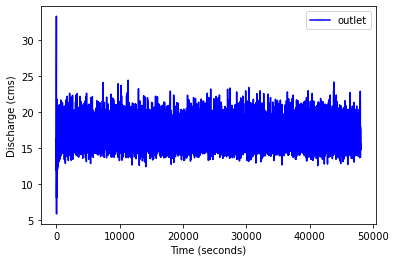

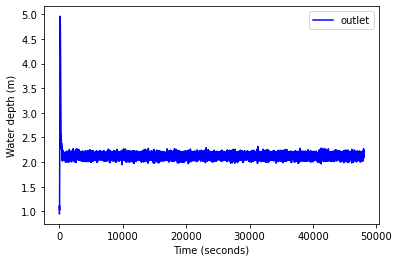

In [79]:
## Plotting hydrographs and discharge
fig=plt.figure(2)
plt.plot(hydrograph_time, discharge_at_outlet, "b-", label="outlet")

plt.ylabel("Discharge (cms)")
plt.xlabel("Time (seconds)")
plt.legend(loc="upper right")
fig.savefig(f"Hima_results/runoff_discharge.jpeg")

fig=plt.figure(3)
plt.plot(hydrograph_time, height_at_outlet, "b-", label="outlet")
plt.ylabel("Water depth (m)")
plt.xlabel("Time (seconds)")
plt.legend(loc="upper right")
fig.savefig("Hima_results/runoff_waterdepth.jpeg")

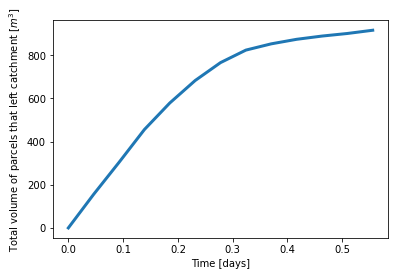

In [80]:
## Plotting sediment volume
parcel_vol_on_grid = parcels.dataset["volume"].values
parcel_vol_on_grid[parcels.dataset["element_id"].values==-2]=0

sum_parcel_vol_on_grid = np.sum(parcel_vol_on_grid, axis=0)

#plt.figure(figsize=(8,6))
plt.plot(np.asarray(parcels.time_coordinates)/(60*60*24), 
         sum_parcel_vol_on_grid[0]-sum_parcel_vol_on_grid,
         '-',
         linewidth=3, 
        )
plt.ylabel('Total volume of parcels that left catchment $[m^3]$')
plt.xlabel('Time [days]')
plt.show() 